In [2]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import librosa

2025-03-21 00:45:23.074483: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-21 00:45:23.082003: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742517923.090569   63300 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742517923.093068   63300 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-21 00:45:23.103598: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
HEALTHY_FILE = "/mnt/f/mars_global_acoustic_study/maldives_acoustics/H1_M2/20211111_234000.WAV"
DEGRADED_FILE = "/mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211101_190800.WAV"

In [4]:
def load_wav_16k_mono(filename):
    # Read and decode the WAV file
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)  # shape: [orig_length]
    
    # Define sample rates
    orig_sr = 44100  # adjust if needed
    target_sr = 16000
    
    # Compute new length
    orig_length = tf.shape(wav)[0]
    new_length = tf.cast(tf.cast(orig_length, tf.float32) * (target_sr / orig_sr), tf.int32)
    
    # Expand dims to create a 4D tensor [batch, height, width, channels]
    # Here we treat the audio as a 1-row image where width = number of samples.
    wav_expanded = tf.expand_dims(wav, 0)       # shape: [1, orig_length]
    wav_expanded = tf.expand_dims(wav_expanded, 0)  # shape: [1, 1, orig_length]
    wav_expanded = tf.expand_dims(wav_expanded, -1) # shape: [1, 1, orig_length, 1]
    
    # Resize the "width" from orig_length to new_length; height remains 1.
    wav_resized = tf.image.resize(wav_expanded, size=[1, new_length], method='bilinear')
    
    # Remove extra dimensions: batch, height, and channel.
    wav_resized = tf.squeeze(wav_resized, axis=[0, 1, 3])  # final shape: [new_length]
    
    return wav_resized

In [5]:
wave = load_wav_16k_mono(HEALTHY_FILE)
nwave = load_wav_16k_mono(DEGRADED_FILE)

I0000 00:00:1742517924.298159   63300 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20594 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


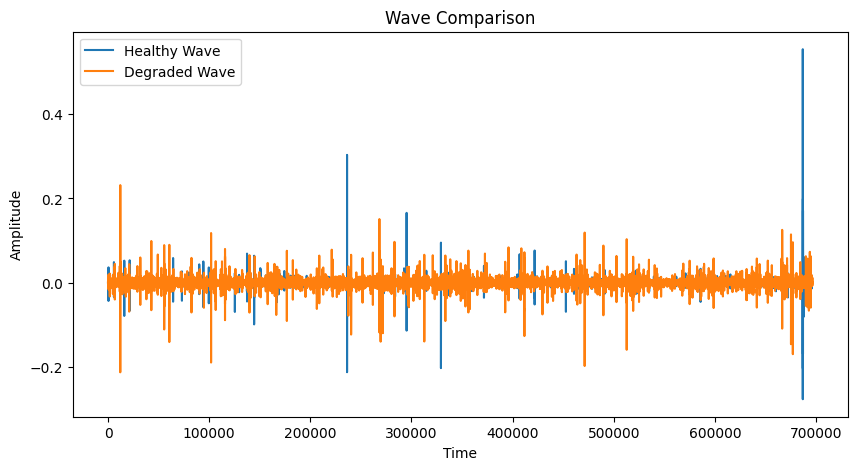

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(wave, label='Healthy Wave')
plt.plot(nwave, label='Degraded Wave')
plt.title("Wave Comparison")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()  # Displays the legend with the given labels
plt.show()

In [7]:
audio = "/mnt/f/mars_global_acoustic_study/maldives_acoustics/"

In [24]:

import glob
import wave
import tensorflow as tf

def is_sixty_seconds_file(path):
    try:
        with wave.open(path, 'rb') as wf:
            frames = wf.getnframes()
            sr = wf.getframerate()
            # Check if duration is exactly 60 seconds.
            return frames == sr * 60
    except Exception as e:
        return False

# Get all healthy files using glob.
healthy_files = glob.glob(audio + "H*/*.WAV")
# Filter healthy files for only those that are exactly 60 seconds.
sixty_second_healthy_files = [f for f in healthy_files if is_sixty_seconds_file(f)]
# Create the tf.data.Dataset from the filtered list.
pos = tf.data.Dataset.from_tensor_slices(sixty_second_healthy_files)

# Do the same for degraded files.
degraded_files = glob.glob(audio + "D*/*.WAV")
sixty_second_degraded_files = [f for f in degraded_files if is_sixty_seconds_file(f)]
neg = tf.data.Dataset.from_tensor_slices(sixty_second_degraded_files)
# Then attach labels
positives = pos.map(lambda file: (file, tf.constant(1, dtype=tf.int32)))
negatives = neg.map(lambda file: (file, tf.constant(0, dtype=tf.int32)))
data = positives.concatenate(negatives)


In [27]:
sixty_second_healthy_files

['/mnt/f/mars_global_acoustic_study/maldives_acoustics/H1_M2/20211023_162400.WAV',
 '/mnt/f/mars_global_acoustic_study/maldives_acoustics/H1_M2/20211023_162800.WAV',
 '/mnt/f/mars_global_acoustic_study/maldives_acoustics/H1_M2/20211023_163200.WAV',
 '/mnt/f/mars_global_acoustic_study/maldives_acoustics/H1_M2/20211023_163600.WAV',
 '/mnt/f/mars_global_acoustic_study/maldives_acoustics/H1_M2/20211023_164000.WAV',
 '/mnt/f/mars_global_acoustic_study/maldives_acoustics/H1_M2/20211023_164400.WAV',
 '/mnt/f/mars_global_acoustic_study/maldives_acoustics/H1_M2/20211023_164800.WAV',
 '/mnt/f/mars_global_acoustic_study/maldives_acoustics/H1_M2/20211023_165200.WAV',
 '/mnt/f/mars_global_acoustic_study/maldives_acoustics/H1_M2/20211023_165600.WAV',
 '/mnt/f/mars_global_acoustic_study/maldives_acoustics/H1_M2/20211023_170000.WAV',
 '/mnt/f/mars_global_acoustic_study/maldives_acoustics/H1_M2/20211023_170400.WAV',
 '/mnt/f/mars_global_acoustic_study/maldives_acoustics/H1_M2/20211023_170800.WAV',
 '/m

In [25]:
neg

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [23]:
positives

<_MapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [9]:
len(data)

46700

In [10]:
#pos = tf.data.Dataset.list_files(audio + "H*/*.WAV")
#neg = tf.data.Dataset.list_files(audio + "D*/*.WAV")

In [11]:
#positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
#negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
#data = positives.concatenate(negatives)

In [12]:
#len(data)

In [13]:
max_files = 1000

lengths = []
processed_files = 0

# Iterate through each subfolder in the audio directory
for folder in os.listdir(audio):
    # Only process folders that start with 'H' (Healthy)
    if folder.startswith('H'):
        folder_path = os.path.join(audio, folder)
        # Process only .wav files (case-insensitive)
        for file in os.listdir(folder_path):
            if file.lower().endswith('.wav'):
                file_path = os.path.join(folder_path, file)
                try:
                    tensor_wave = load_wav_16k_mono(file_path)
                    lengths.append(len(tensor_wave))
                    processed_files += 1
                except Exception as e:
                    print(f"Skipping file {file_path} due to error: {e}")
                # Break out of loop if we've processed the maximum number of files
                if processed_files >= max_files:
                    break
        if processed_files >= max_files:
            break

print(f"Processed {processed_files} healthy audio files.")

Processed 1000 healthy audio files.


In [14]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=696598>

In [15]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=696598>

In [16]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=696598>

In [17]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [18]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [19]:
spectrogram, label = preprocess(filepath, label)

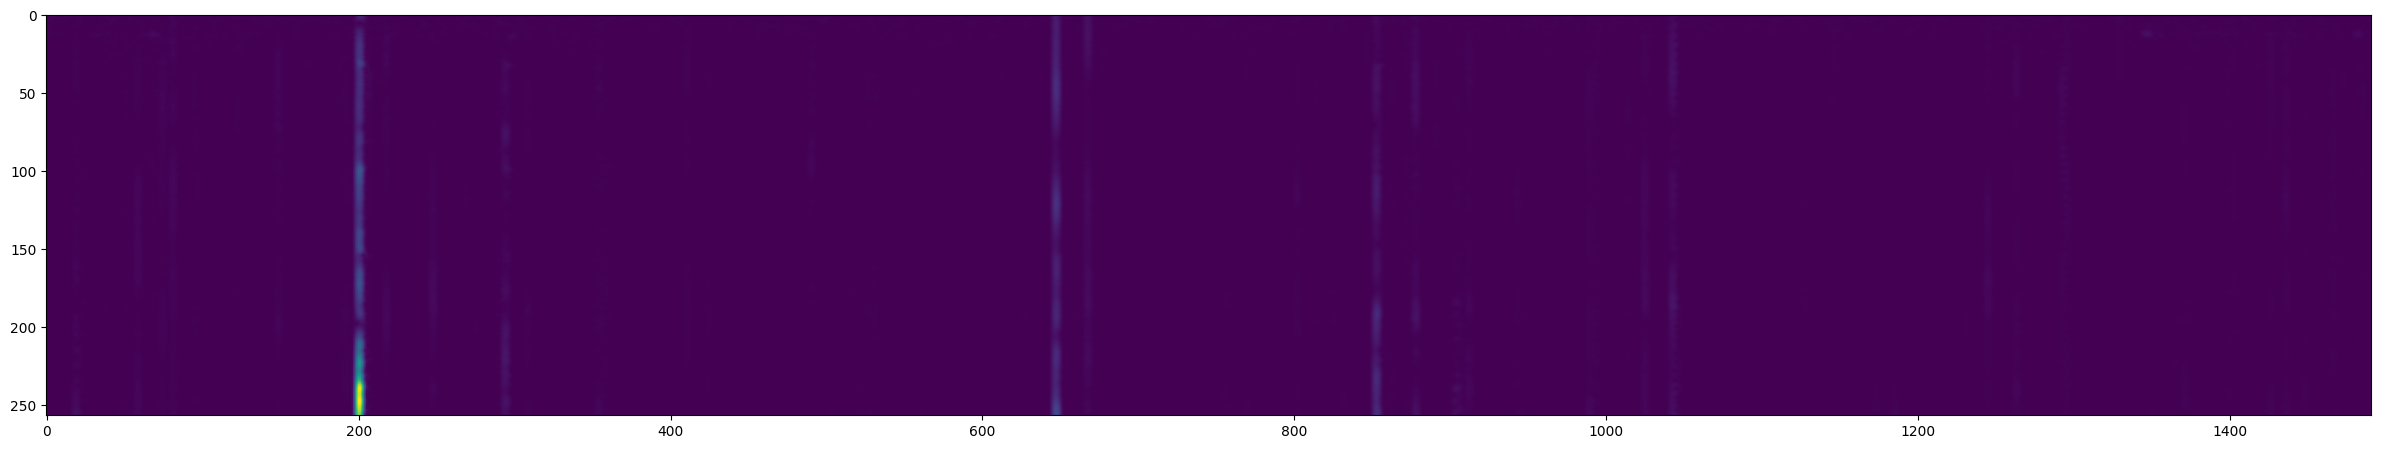

In [20]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [21]:
data = data.map(preprocess)
#data = data.apply(tf.data.experimental.ignore_errors())
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [22]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [46]:
len(data)*0.7

2043.3

In [47]:
train = data.take(2190)
test = data.skip(2190).take(731)

In [48]:
samples, labels = train.as_numpy_iterator().next()

2025-03-13 19:08:50.276545: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [49]:
samples.shape

(16, 1491, 257, 1)

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, GlobalAveragePooling2D

In [51]:
"""
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
"""


"\nmodel = Sequential()\nmodel.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))\nmodel.add(Conv2D(16, (3,3), activation='relu'))\nmodel.add(Flatten())\nmodel.add(Dense(128, activation='relu'))\nmodel.add(Dense(1, activation='sigmoid'))\n"

In [52]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [53]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [54]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 1489, 255, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1487, 253, 16)  │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,785 (18.69 KB)

 Trainable params: 4,785 (18.69 KB)

 Non-trainable params: 0 (0.00 B)

## 7.3 Fit Model, View Loss and KPI Plots

In [55]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
 527/2190 ━━━━━━━━━━━━━━━━━━━━ 3:35 130ms/step - loss: 0.1727 - precision_1: 0.9981 - recall_1: 0.9870

2025-03-13 19:10:16.583580: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (mklcpu) ran out of memory trying to allocate 7.32MiB (rounded to 7680000)requested by op DecodeWav
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-03-13 19:10:16.596474: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1053] BFCAllocator dump for mklcpu
2025-03-13 19:10:16.596715: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (256): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2025-03-13 19:10:16.596730: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2025-03-13 19:10:16.596733: I external/local_x

ResourceExhaustedError: Graph execution error:

Detected at node resize/ResizeBilinear defined at (most recent call last):
<stack traces unavailable>
Detected at node resize/ResizeBilinear defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  Error in user-defined function passed to MapDataset:27 transformation with iterator: Iterator::Root::Prefetch::FiniteTake::Prefetch::BatchV2::Shuffle::MemoryCacheImpl::ParallelMapV2: OOM when allocating tensor with shape[1,1,696598,1] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[{{node resize/ResizeBilinear}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[IteratorGetNext/_4]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  Error in user-defined function passed to MapDataset:27 transformation with iterator: Iterator::Root::Prefetch::FiniteTake::Prefetch::BatchV2::Shuffle::MemoryCacheImpl::ParallelMapV2: OOM when allocating tensor with shape[1,1,696598,1] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[{{node resize/ResizeBilinear}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_58294]

2025-03-13 19:10:38.876914: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (mklcpu) ran out of memory trying to allocate 7.32MiB (rounded to 7680000)requested by op DecodeWav
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-03-13 19:10:38.877432: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1053] BFCAllocator dump for mklcpu
2025-03-13 19:10:38.877448: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (256): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2025-03-13 19:10:38.877452: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2025-03-13 19:10:38.877454: I external/local_x

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
yhat = model.predict(X_test)

## 8.2 Convert Logits to Classes 

In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

# 9. Build Forest Parsing Functions

## 9.1 Load up MP3s

In [ ]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [ ]:
wav = load_mp3_16k_mono(mp3)

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

## 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [ ]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9.3 Convert Longer Clips into Windows and Make Predictions

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

## 9.4 Group Consecutive Detections

In [ ]:
from itertools import groupby

In [ ]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [ ]:
calls

# 10. Make Predictions

## 10.1 Loop over all recordings and make predictions

In [ ]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

In [ ]:
results

## 10.2 Convert Predictions into Classes

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

## 10.3 Group Consecutive Detections

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

# 11. Export Results

In [ ]:
import csv

In [ ]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])